### Importe de librerias

In [216]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot as plt
from joblib import dump

np.random.seed(1)
tf.random.set_seed(1)

# Redes Neuronales

Datasets a utilizar

In [217]:
#datasets normales
ds_train = pd.read_csv('properati_argentina_train.csv')
ds_test = pd.read_csv('properati_argentina_test.csv')

### Ingenieria de caracteristicas para datasets compelto

In [218]:
ds_train.head()

,Unnamed: 0,id,latitud,longitud,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,precioxm2_relativo_q
0,0,CLj2GNCsBreAzTKFXCaLIQ==,-34.601807,-58.469965,Departamento,2.0,1.0,53.0,49.0,80000.0,bajo
1,1,TvqKIPzzT1urYfVhh8tC7w==,-34.580088,-58.424965,Departamento,2.0,1.0,35.0,35.0,79900.0,medio
2,2,QRs3RUjw1RS5/WRne8ApbA==,-34.551481,-58.452358,Departamento,1.0,1.0,25.0,20.0,69000.0,medio
3,3,ju90QBsV36i7DCOOWCJpaA==,-34.632290,-58.464844,Departamento,5.0,3.0,75.0,75.0,150000.0,medio
4,4,uxD4SK3jtGbmxfIlN03UMQ==,-34.549279,-58.463074,Departamento,2.0,1.0,46.0,34.0,85000.0,bajo


In [219]:
#dropeamos Unamed:0
ds_train.drop(columns=["Unnamed: 0"], inplace=True)
ds_test.drop(columns=["Unnamed: 0"], inplace=True)

#cambio nombre de columna precioxm2_relativo_q
ds_train.rename(columns={'precioxm2_relativo_q':'tipo_precio'}, inplace=True)
ds_test.rename(columns={'precioxm2_relativo_q':'tipo_precio'}, inplace=True)

Aplicamos dummies a la variable property_type

In [220]:
ds_train = pd.get_dummies(ds_train, columns=["property_type"], drop_first=True)

ds_test =  pd.get_dummies(ds_test, columns=["property_type"], drop_first=True)

In [221]:
ds_train['tipo_precio'].unique()

array(['bajo', 'medio', 'alto'], dtype=object)

Tengo que pasar estas clases a numeros para que funcionen con clasificacion. Hago un label encoder

In [222]:
tipo_precio_replace = {'bajo':0, 'medio':1, 'alto':2}

ds_train.loc[:, 'tipo_precio'].replace(tipo_precio_replace, inplace=True)
ds_test.loc[:, 'tipo_precio'].replace(tipo_precio_replace, inplace=True)

In [223]:
ds_train.head()

,id,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,tipo_precio,property_type_Departamento,property_type_PH
0,CLj2GNCsBreAzTKFXCaLIQ==,-34.601807,-58.469965,2.0,1.0,53.0,49.0,80000.0,0,1,0
1,TvqKIPzzT1urYfVhh8tC7w==,-34.580088,-58.424965,2.0,1.0,35.0,35.0,79900.0,1,1,0
2,QRs3RUjw1RS5/WRne8ApbA==,-34.551481,-58.452358,1.0,1.0,25.0,20.0,69000.0,1,1,0
3,ju90QBsV36i7DCOOWCJpaA==,-34.632290,-58.464844,5.0,3.0,75.0,75.0,150000.0,1,1,0
4,uxD4SK3jtGbmxfIlN03UMQ==,-34.549279,-58.463074,2.0,1.0,46.0,34.0,85000.0,0,1,0


In [224]:
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68012 entries, 0 to 68011
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          68012 non-null  object 
 1   latitud                     68012 non-null  float64
 2   longitud                    68012 non-null  float64
 3   property_rooms              68012 non-null  float64
 4   property_bedrooms           68012 non-null  float64
 5   property_surface_total      68012 non-null  float64
 6   property_surface_covered    68012 non-null  float64
 7   property_price              68012 non-null  float64
 8   tipo_precio                 68012 non-null  int64  
 9   property_type_Departamento  68012 non-null  uint8  
 10  property_type_PH            68012 non-null  uint8  
dtypes: float64(7), int64(1), object(1), uint8(2)
memory usage: 4.8+ MB


## Regresion

Funcion para graficar

In [225]:
features_regression = ['longitud', 'latitud', 'property_surface_total', "property_type_PH", "property_type_Departamento", "property_bedrooms"]
target_regression = ['property_price']

x_train_regress = ds_train.loc[:, features_regression]
x_test_regress = ds_test.loc[:, features_regression]
y_train_regress = ds_train.loc[:, target_regression]
y_test_regress = ds_test.loc[:, target_regression]

In [226]:
sscaler = StandardScaler()
sscaler.fit(x_train_regress)

StandardScaler()

In [227]:
x_train_regress = sscaler.transform(x_train_regress)
x_test_regress = sscaler.transform(x_test_regress)

#### Modelo de regresion

In [228]:
in_regress = len(features_regression)
out_regress = len(target_regression)

In [229]:
def regression_model_builder(hp):
    max_neurons = 50
    model = keras.Sequential()
    model.add(keras.Input(shape=(in_regress,)))
    
    hp_units_1 = hp.Int('units_1', min_value=1, max_value=max_neurons, step=1)
    hp_activation_1 = hp.Choice('activation_1', values=['tanh', 'sigmoid'])
    model.add(keras.layers.Dense(units=hp_units_1, activation=hp_activation_1, name="layer1"))
    
    hp_units_2 = hp.Int('units_2', min_value=1, max_value=max_neurons, step=1)
    hp_activation_2 = hp.Choice('activation_2', values=['relu', 'tanh', 'sigmoid'])
    model.add(keras.layers.Dense(units=hp_units_2, activation=hp_activation_2, name="layer2"))
    
    model.add(keras.layers.Dense(units=out_regress, name="output"))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.RootMeanSquaredError()]
    )
    
    return model

Algunas notas sobre la funcion para construir el modelo:

* Decidimos usar 2 ocultas con un maximo de 50 neuronas por capa. Estos números fueron arbitrarios pero prombamos algunos otros y no conseguimos mejores métricas.

* La función de activación "relu" en la primera capa causaba problemas (hacia que la funcion de perdida diera nan), por lo que solo usamos la tangencial o la sigmoidea. Estas 3 funciones son las que se ven comunmente en problemas de regresión.

In [206]:
regress_tuner = kt.RandomSearch(
    regression_model_builder,
    objective='val_loss',
    max_trials=20,
   
)

In [207]:
regress_history = regress_tuner.search(x_train_regress, y_train_regress.to_numpy(), epochs=100, batch_size=700, validation_split=0.2)

Trial 20 Complete [00h 00m 14s]
val_loss: nan

Best val_loss So Far: 15591652352.0
Total elapsed time: 00h 05m 12s
INFO:tensorflow:Oracle triggered exit


In [208]:
best_regress_hps = regress_tuner.get_best_hyperparameters()[0]
print("Hiperparametros Optimos Encontrados")
print("  · Neuronas primera capa: ", best_regress_hps.get('units_1'))
print("  · Activavion primera capa: ", best_regress_hps.get('activation_1'))
print("  · Neuronas segunda capa: ", best_regress_hps.get('units_2'))
print("  · Activavion segunda capa: ", best_regress_hps.get('activation_2'))
print("  · Learning rate: ", best_regress_hps.get('learning_rate'))


Hiperparametros Optimos Encontrados
  · Neuronas primera capa:  6
  · Activavion primera capa:  tanh
  · Neuronas segunda capa:  46
  · Activavion segunda capa:  sigmoid
  · Learning rate:  0.01


Una vez que obtenemos lo hiperparametros optimos, creamos una red con esos parametros.

In [230]:
regress_model = keras.Sequential(
    [
        keras.Input(shape=(in_regress,)),
        keras.layers.Dense(units=15, activation='tanh', name="layer1"),
        keras.layers.Dense(units=8, activation='relu', name="layer2"),
        keras.layers.Dense(units=out_regress, name="output")
    ]
)

In [231]:
regress_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 15)                105       
                                                                 
 layer2 (Dense)              (None, 8)                 128       
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 242
Trainable params: 242
Non-trainable params: 0
_________________________________________________________________


In [232]:
regress_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=1e-6),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

In [233]:
regress_model.fit(x_train_regress, y_train_regress.to_numpy(), epochs=100, batch_size=700, validation_split=0.2)

Epoch 1/100
78/78 [==============================] - 2s 10ms/step - loss: 22610257920.0000 - root_mean_squared_error: 150367.0781 - val_loss: 15250327552.0000 - val_root_mean_squared_error: 123492.2188
Epoch 2/100
78/78 [==============================] - 0s 5ms/step - loss: 13808149504.0000 - root_mean_squared_error: 117508.0859 - val_loss: 28600829952.0000 - val_root_mean_squared_error: 169117.7969
Epoch 3/100
78/78 [==============================] - 0s 5ms/step - loss: 12728035328.0000 - root_mean_squared_error: 112818.5938 - val_loss: 25648355328.0000 - val_root_mean_squared_error: 160151.0469
Epoch 4/100
78/78 [==============================] - 0s 5ms/step - loss: 13074033664.0000 - root_mean_squared_error: 114341.7422 - val_loss: 20450422784.0000 - val_root_mean_squared_error: 143004.9688
Epoch 5/100
78/78 [==============================] - 0s 5ms/step - loss: 10656921600.0000 - root_mean_squared_error: 103232.3672 - val_loss: 10764926976.0000 - val_root_mean_squared_error: 103754

In [213]:
y_pred_regress = regress_model.predict(x_test_regress)

532/532 [==============================] - 0s 746us/step


In [214]:
regress_rmse = mean_squared_error(
        y_true  = y_test_regress,
        y_pred  = y_pred_regress,
        squared = False
       )

print(f"La raiz del error cuadratico medio del test es: {regress_rmse:,.2f}")

regress_mse = mean_squared_error(
        y_true  = y_test_regress,
        y_pred  = y_pred_regress,
        squared = True
       )

print(f"El error cuadratico medio del test es: {regress_mse:,.2f}")


r2 = r2_score(
        y_true  = y_test_regress,
        y_pred  = y_pred_regress,

)

print("El R2 score en datos del test es: " + str((r2)))

La raiz del error cuadratico medio del test es: 76,997.36
El error cuadratico medio del test es: 5,928,594,048.88
El R2 score en datos del test es: 0.7110920315365297


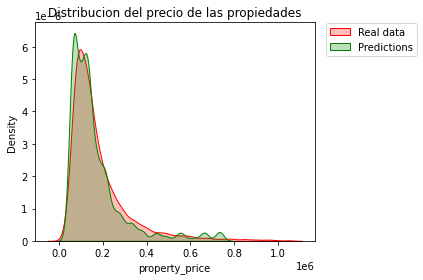

In [215]:
fig, ax = plt.subplots()
sns.kdeplot(data=y_test_regress.squeeze(), ax=ax, color='red', fill=True, label='Real data')
sns.kdeplot(data=y_pred_regress.squeeze(), ax=ax, color='green', fill=True, label='Predictions')
ax.legend(bbox_to_anchor=(1.02, 1.02), loc='upper left')
plt.title("Distribucion del precio de las propiedades")
plt.tight_layout()
plt.show()

#### Conclusiones

Al final probando diferentes valores de epocas y batch size logramos que el modelo prediga el precio, aunque con unas metricas inferiores a las que se lograron en el TP1 con knn y xgboost.

Luego probamos usar mas variables regresoras pero las metricas resultaban peores asi que decidimos hacer la regresion solamente con 6 variables: 'longitud', 'latitud', 'property_surface_total', "property_type_PH", "property_type_Departamento" y "property_bedrooms".

## Clasificacion

In [10]:
ds_train.columns

Index(['id', 'latitud', 'longitud', 'property_rooms', 'property_bedrooms',
       'property_surface_total', 'property_surface_covered', 'property_price',
       'tipo_precio', 'property_type_Departamento', 'property_type_PH'],
      dtype='object')

In [235]:
features_classification = ['longitud', 'latitud', 'property_rooms', 'property_bedrooms',
                           'property_surface_total', 'property_surface_covered',
                           'property_type_Departamento', 'property_type_PH']
target_classification = 'tipo_precio'

x_train_class = ds_train.loc[:, features_classification]
x_test_class = ds_test.loc[:, features_classification]
y_train_class = ds_train.loc[:, target_classification]
y_test_class = ds_test.loc[:, target_classification]

In [236]:
numeric_features = ['longitud', 'latitud', 'property_rooms', 'property_bedrooms',
                    'property_surface_total', 'property_surface_covered']

sscaler = StandardScaler()
sscaler.fit(x_train_class.loc[:, numeric_features])

StandardScaler()

In [237]:
x_train_class.loc[:, numeric_features] = sscaler.transform(x_train_class.loc[:, numeric_features])
x_test_class.loc[:, numeric_features] = sscaler.transform(x_test_class.loc[:, numeric_features])

#### Modelo de clasificacion

In [238]:
in_class = len(features_classification)
out_class = len(y_train_class.unique())

In [239]:
def classification_model_builder(hp):
    max_neurons = 50
    model = keras.Sequential()
    model.add(keras.Input(shape=(in_class,)))
    
    hp_units_1 = hp.Int('units_1', min_value=out_class, max_value=max_neurons, step=1)
    hp_activation_1 = hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid', 'softmax'])
    model.add(keras.layers.Dense(units=hp_units_1, activation=hp_activation_1, name="layer1"))
    
    hp_units_2 = hp.Int('units_2', min_value=out_class, max_value=max_neurons, step=1)
    hp_activation_2 = hp.Choice('activation_2', values=['relu', 'tanh', 'sigmoid', 'softmax'])
    model.add(keras.layers.Dense(units=hp_units_2, activation=hp_activation_2, name="layer2"))
    
    model.add(keras.layers.Dense(units=out_class, activation='softmax', name="output"))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

La funcion para construir el modelo practicamente igual que a la de regresión. Agrego la función de activación softmax ya que se usa mucho en problemas de clasificacion y modifico la funcion de perdida.

In [20]:
class_tuner = kt.RandomSearch(
    classification_model_builder,
    objective='val_accuracy',
    max_trials=20
)

In [22]:
class_history = class_tuner.search(x_train_class, y_train_class.to_numpy(), epochs=100, batch_size=700, validation_split=0.2)

Trial 20 Complete [00h 00m 18s]
val_accuracy: 0.5001837611198425

Best val_accuracy So Far: 0.5922958254814148
Total elapsed time: 00h 05m 27s
INFO:tensorflow:Oracle triggered exit


In [23]:
best_class_hps = class_tuner.get_best_hyperparameters()[0]
print("Hiperparametros Optimos Encontrados")
print("  · Neuronas primera capa: ", best_class_hps.get('units_1'))
print("  · Activavion primera capa: ", best_class_hps.get('activation_1'))
print("  · Neuronas segunda capa: ", best_class_hps.get('units_2'))
print("  · Activavion segunda capa: ", best_class_hps.get('activation_2'))
print("  · Learning rate: ", best_class_hps.get('learning_rate'))

Hiperparametros Optimos Encontrados
  · Neuronas primera capa:  21
  · Activavion primera capa:  tanh
  · Neuronas segunda capa:  30
  · Activavion segunda capa:  softmax
  · Learning rate:  0.1


Una vez que obtenemos lo hiperparametros optimos, creamos una red con esos parametros.

In [240]:
class_model = keras.Sequential(
    [
        keras.Input(shape=(in_class,)),
        keras.layers.Dense(units=21, activation='tanh', name="layer1"),
        keras.layers.Dense(units=30, activation='softmax', name="layer2"),
        keras.layers.Dense(units=out_class, activation='softmax', name="output")
    ]
)

In [241]:
class_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 21)                189       
                                                                 
 layer2 (Dense)              (None, 30)                660       
                                                                 
 output (Dense)              (None, 3)                 93        
                                                                 
Total params: 942
Trainable params: 942
Non-trainable params: 0
_________________________________________________________________


In [243]:
class_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.1),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [244]:
class_model.fit(x_train_class, y_train_class.to_numpy(), epochs=100, batch_size=700, validation_split=0.2)

Epoch 1/100
78/78 [==============================] - 2s 11ms/step - loss: 1.0495 - accuracy: 0.4951 - val_loss: 1.0382 - val_accuracy: 0.5003
Epoch 2/100
78/78 [==============================] - 0s 6ms/step - loss: 1.0376 - accuracy: 0.4997 - val_loss: 1.0366 - val_accuracy: 0.5003
Epoch 3/100
78/78 [==============================] - 0s 6ms/step - loss: 1.0360 - accuracy: 0.4997 - val_loss: 1.0350 - val_accuracy: 0.5003
Epoch 4/100
78/78 [==============================] - 0s 6ms/step - loss: 1.0344 - accuracy: 0.4997 - val_loss: 1.0334 - val_accuracy: 0.5003
Epoch 5/100
78/78 [==============================] - 0s 6ms/step - loss: 1.0326 - accuracy: 0.4997 - val_loss: 1.0316 - val_accuracy: 0.5003
Epoch 6/100
78/78 [==============================] - 0s 6ms/step - loss: 1.0306 - accuracy: 0.4997 - val_loss: 1.0295 - val_accuracy: 0.5003
Epoch 7/100
78/78 [==============================] - 0s 6ms/step - loss: 1.0282 - accuracy: 0.4997 - val_loss: 1.0271 - val_accuracy: 0.5003
Epoch 8/100


In [19]:
y_pred_class = class_model.predict(x_test_class)

532/532 [==============================] - 0s 722us/step


In [20]:
y_pred_class = np.argmax(y_pred_class ,axis = 1)

In [22]:
print("  Accuracy : %.3f" % accuracy_score(y_test_class, y_pred_class))
print("  Precision: %.3f" % precision_score(y_test_class, y_pred_class, average='macro'))
print("     Recall: %.3f" % recall_score(y_test_class, y_pred_class, average='macro'))
print("  f-measure: %.3f" % f1_score(y_test_class, y_pred_class, average='macro'))

  Accuracy : 0.594
  Precision: 0.607
     Recall: 0.539
  f-measure: 0.557


<Figure size 2000x1000 with 0 Axes>

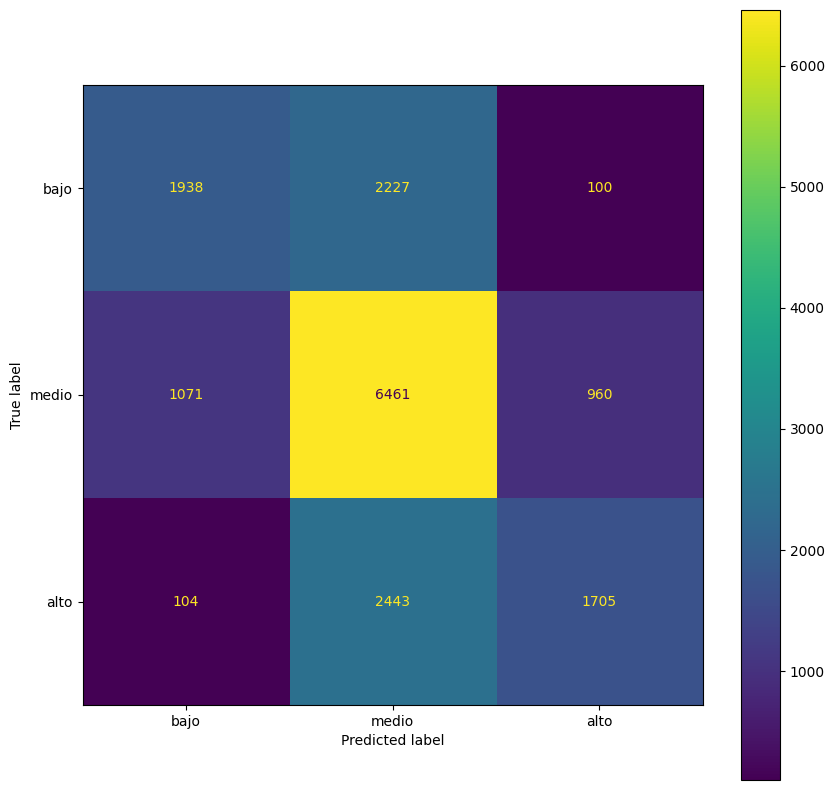

In [29]:
class_labels = ["bajo", "medio", "alto"]

plt.figure(figsize=(20,10))
cm = confusion_matrix(y_test_class, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(10,10))
#ax.title.set_text(legend)
disp.plot(ax=ax)
plt.show()

#### Conclusiones Clasificacion

A diferencia de el modelo de regresion, no fue dificil hacer que el modelo prediga las clases.
Sin embargo, incluso optimizando hiperparametros, la metricas obtenidas no son buenas. Los resultados obtenidos en el TP1 usando knn y arboles de decision fueron mas satisfactorios, y los modelos, mas simples.

## Conclusiones Redes Neuronales

El uso de redes neuronales trajo implicó una complejidad mayor comparada con la de los modelos del TP1, y a pesar de eso los resultados obtenidos fueron peores.
Esto en parte puede que se deba a un error de nuestra parte, pero no logramos encontrar una solucion.

Principales referencias:
* https://keras.io/api/
* https://keras.io/keras_tuner/
* https://www.tensorflow.org/tutorials/keras/keras_tuner